<a href="https://colab.research.google.com/github/silverfuryK/Turbulence-Generation/blob/main/Pix2Pix_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
CUDA_LAUNCH_BLOCKING=1
import argparse
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

#from models import *
#from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch
import random
import matplotlib.pyplot as plt

In [ ]:
!pip install perlin-noise
from perlin_noise import PerlinNoise

  Created wheel for perlin-noise: filename=perlin_noise-1.7-cp37-none-any.whl size=3761 sha256=3ff0a980ead549fc69802e2590444af3272d0de1f261ec9ef756f363bd6be455
  Stored in directory: /root/.cache/pip/wheels/78/8f/cb/565ce00d57b7a7eef5a83f3faaa8796e7e077412b8e16bc653
Successfully built perlin-noise


In [ ]:
def perlin_img_gen_stack(inp_x, inp_y, inp_ch, batch, octave):
  noise = PerlinNoise(octaves=octave)
  pic = np.empty((batch,inp_ch,inp_x,inp_y))
  #for k in range(inp_ch):
  for b in range(batch):
    for j in range(inp_y):
      for i in range(inp_x):
        pic[b,:,i,j] = noise([j/inp_y, i/inp_x])
  #pic = np.expand_dims(pic,axis = 0)
  #pic[0:inp_ch] = pic[0]
  return pic

TypeError: ignored

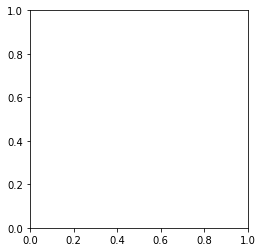

In [ ]:
noise = PerlinNoise(octaves=10, seed=1)
ch, xpix, ypix =4, 8, 8
pic = [[noise([k/ch, i/xpix, j/ypix]) for k in range(ch) for j in range(xpix)] for i in range(ypix)]
plt.imshow(pic[0])

In [ ]:
len(pic

AttributeError: ignored

In [ ]:
data = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/data_chfirst.npy')
data_np = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/data_new_nonan.npy')
params_data = np.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/np_arrays/params_data_norm.npy')

data = torch.tensor(data)
params_data = torch.tensor(params_data[1:])
if torch.cuda.is_available():
    data = data.to(device = 'cuda', dtype=torch.float)
    print('cuda available')
    params_data = params_data.to(device = 'cuda', dtype=torch.float)
    
data = transforms.functional.resize(data,[256,256])

train_dataset = (data, params_data)
# train_loader = torch.utils.data.DataLoader(data,shuffle=True,   batch_size = 1)

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,   batch_size = 1)


cuda available


In [ ]:
# arguments
import sys
sys.argv=['']
del sys
os.makedirs("gan/images", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=800, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="facades", help="name of the dataset")
parser.add_argument("--batch_size", type=int, default=1, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--img_height", type=int, default=256, help="size of image height")
parser.add_argument("--img_width", type=int, default=256, help="size of image width")
parser.add_argument("--channels", type=int, default=16, help="number of image channels")
parser.add_argument(
    "--sample_interval", type=int, default=500, help="interval between sampling of images from generators"
)
parser.add_argument("--checkpoint_interval", type=int, default=-1, help="interval between model checkpoints")
opt = parser.parse_args()
print(opt)

os.makedirs("images/%s" % opt.dataset_name, exist_ok=True)
os.makedirs("saved_models/%s" % opt.dataset_name, exist_ok=True)

cuda = True if torch.cuda.is_available() else False
img_shape = (opt.channels, opt.img_height, opt.img_width)

Namespace(b1=0.5, b2=0.999, batch_size=1, channels=16, checkpoint_interval=-1, dataset_name='facades', decay_epoch=100, epoch=0, img_height=256, img_width=256, lr=0.0002, n_cpu=8, n_epochs=800, sample_interval=500)


In [ ]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

In [ ]:
patch = (1, opt.img_height // 32, opt.img_width // 32) # 1,16,16

#patch = (1, opt.img_height // 4 ** 4, opt.img_width // 4 ** 4) # 1,1,1


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [ ]:

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(0.2)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        #skip skip layers
        d = torch.zeros(skip_input.shape)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=opt.channels, out_channels=opt.channels):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 256 > 128
        self.down2 = UNetDown(64, 128)                          # 128 > 64
        self.down3 = UNetDown(128, 256)                         # 64 > 32
        self.down4 = UNetDown(256, 512, dropout=0.5)            # 32 > 16
        self.down5 = UNetDown(512, 512, dropout=0.5)            # 16 > 8
        self.down6 = UNetDown(512, 512, dropout=0.5)            # 8 > 4
        self.down7 = UNetDown(512, 512, dropout=0.5)            # 4 > 2
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 2 > 1

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )
        self.lin = nn.Linear(512+9,512)

    def forward(self, x, params):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        #print(d1.shape)
        d2 = self.down2(d1)
        #print(d2.shape)
        d3 = self.down3(d2)
        #print(d3.shape)
        d4 = self.down4(d3)
        #print(d4.shape)
        d5 = self.down5(d4)
        #print(d5.shape)
        d6 = self.down6(d5)
        #print(d6.shape)
        d7 = self.down7(d6)
        #print(d7.shape)
        d8 = self.down8(d7)
        #print(d8.shape)

        d8 = d8.view(d1.shape[0], 512)
        d8 = torch.cat((d8,params),-1)
        d8 = self.lin(d8)
        d8 = d8.view(d1.shape[0], 512, 1, 1)
        
        u1 = self.up1(d8 + params.shape[-1], d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=opt.channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),   #32
            *discriminator_block(512, 1024),   #16
            #*discriminator_block(1024, 1024),  #8
            #*discriminator_block(1024, 1024),  #4
            #*discriminator_block(1024, 1024),  #2
            #*discriminator_block(1024, 1024),  #1
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(1024, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        dis_out = self.model(img_input)
        #print(dis_out.shape)
        return dis_out

In [ ]:
#og mod 2x

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(1))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(1)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        #skip skip layers
        d = torch.zeros(skip_input.shape)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=opt.channels, out_channels=opt.channels):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64*2, normalize=False) # 256 > 128
        self.down2 = UNetDown(64*2, 128*2)                          # 128 > 64
        self.down3 = UNetDown(128*2, 256*2)                         # 64 > 32
        self.down4 = UNetDown(256*2, 512*2, dropout=0.4)            # 32 > 16
        self.down5 = UNetDown(512*2, 512*2, dropout=0.4)            # 16 > 8
        self.down6 = UNetDown(512*2, 512*2, dropout=0.4)            # 8 > 4
        self.down7 = UNetDown(512*2, 512*2, dropout=0.4)            # 4 > 2
        self.down8 = UNetDown(512*2, 512*2, normalize=False, dropout=0.5) # 2 > 1

        self.up1 = UNetUp(512*2, 512*2, dropout=0.4)
        self.up2 = UNetUp(1024*2, 512*2, dropout=0.4)
        self.up3 = UNetUp(1024*2, 512*2, dropout=0.4)
        self.up4 = UNetUp(1024*2, 512*2, dropout=0.4)
        self.up5 = UNetUp(1024*2, 256*2)
        self.up6 = UNetUp(512*2, 128*2)
        self.up7 = UNetUp(256*2, 64*2)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128*2, out_channels, 4, padding=1),
            nn.Tanh(),
        )
        self.lin = nn.Linear(512*2 +9,512*2)

    def forward(self, x, params):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        #print(d1.shape)
        d2 = self.down2(d1)
        #print(d2.shape)
        d3 = self.down3(d2)
        #print(d3.shape)
        d4 = self.down4(d3)
        #print(d4.shape)
        d5 = self.down5(d4)
        #print(d5.shape)
        d6 = self.down6(d5)
        #print(d6.shape)
        d7 = self.down7(d6)
        #print(d7.shape)
        d8 = self.down8(d7)
        #print(d8.shape)

        d8 = d8.view(-1, 512*2)
        #print(d8.shape)
        #print(params.shape)
        d8 = torch.cat((d8,params),-1)
        #print(d8.shape)
        d8 = self.lin(d8)
        #print(d8.shape)
        d8 = d8.view(-1, 512*2, 1, 1)
        #print(d8.shape)
        
        u1 = self.up1(d8 + params.shape[-1], d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=opt.channels):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128*2),
            *discriminator_block(128*2, 256*2),
            *discriminator_block(256*2, 512*2),
            #*discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512*2, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        dis_out = self.model(img_input)
        #print(dis_out.shape)
        return dis_out

In [ ]:
#no skipping

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(1))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            #nn.ReLU(inplace=True),
            nn.LeakyReLU(1)
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        #skip skip layers
        #d = torch.zeros(skip_input.shape)
        #x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 256 > 128
        self.down2 = UNetDown(64, 128)                          # 128 > 64
        self.down3 = UNetDown(128, 256)                         # 64 > 32
        self.down4 = UNetDown(256, 512, dropout=0.5)            # 32 > 16
        self.down5 = UNetDown(512, 512, dropout=0.5)            # 16 > 8
        self.down6 = UNetDown(512, 512, dropout=0.5)            # 8 > 4
        self.down7 = UNetDown(512, 512, dropout=0.5)            # 4 > 2
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5) # 2 > 1

        self.up1 = UNetUp(512, 1024, dropout=0.5)
        self.up2 = UNetUp(1024, 1024, dropout=0.5)
        self.up3 = UNetUp(1024, 1024, dropout=0.5)
        self.up4 = UNetUp(1024, 1024, dropout=0.5)
        self.up5 = UNetUp(1024, 512)
        self.up6 = UNetUp(512, 256)
        self.up7 = UNetUp(256, 128)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )
        self.lin = nn.Linear(512+9,512)

    def forward(self, x, params):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        #print(d1.shape)
        d2 = self.down2(d1)
        #print(d2.shape)
        d3 = self.down3(d2)
        #print(d3.shape)
        d4 = self.down4(d3)
        #print(d4.shape)
        d5 = self.down5(d4)
        #print(d5.shape)
        d6 = self.down6(d5)
        #print(d6.shape)
        d7 = self.down7(d6)
        #print(d7.shape)
        d8 = self.down8(d7)
        #print(d8.shape)

        d8 = d8.view(d1.shape[0], 512)
        d8 = torch.cat((d8,params),-1)
        d8 = self.lin(d8)
        d8 = d8.view(d1.shape[0], 512, 1, 1)
        
        u1 = self.up1(d8 + params.shape[-1], d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, in_channels=4):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
# Initialize generator and discriminator
generator = GeneratorUNet()
discriminator = Discriminator()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()

if opt.epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/%s/generator_%d.pth" % (opt.dataset_name, opt.epoch)))
    discriminator.load_state_dict(torch.load("saved_models/%s/discriminator_%d.pth" % (opt.dataset_name, opt.epoch)))
else:
    # Initialize weights
    #generator.apply(weights_init_normal)
    #discriminator.apply(weights_init_normal)
    print('ok')


ok


In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(opt.b1, opt.b2))

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def cgan_loss()

In [ ]:


# ----------
#  Training
# ----------
generator.train()
discriminator.train()

bat = 10
dat_len = 600

for epoch in range(opt.n_epochs):
  i = 0
  ind = 0
  # batch loop
  mul = 0
  TlossG = torch.tensor(0).to('cuda', dtype=torch.float)
  TlossD = torch.tensor(0).to('cuda', dtype=torch.float)
  for dat in range(0,int((dat_len/bat))):

    #imgs = data[i]
    
    params = params_data[i]

    # Adversarial ground truths
    imgs = data[dat*bat:(dat+1)*bat]    
    imgs = imgs.to(device = 'cuda')
    imgs = imgs[:,0:]

    
    batch_size = imgs.shape[0]
    
    valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
    

    params = params_data[dat*bat:(dat+1)*bat]



    # Configure input
    #real_imgs = Variable(imgs.type(Tensor))
    real_imgs = imgs

    # Model inputs
    #real_A is the input ie, noise
    #noise_img = torch.rand((imgs.shape[0], opt.channels, 8, 8)).to(device = 'cuda')
    #noise_img = torch.normal(0,0.4,(imgs.shape[0], opt.channels, 8, 8)).to(device = 'cuda')
    '''
    noise_img = torch.empty((batch_size, opt.channels, 8, 8)).to(device = 'cuda')
    #noise_img = transforms.functional.resize(noise_img,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)
    for i in range(0, batch_size):
      #for j in range(0, opt.channels):
      noise_img[i,:] = torch.normal(0,1,(8, 8))
    
    '''
    noise_img = Variable(Tensor(perlin_img_gen_stack(32,32, opt.channels,batch_size, 3)))
    noise_img = transforms.functional.resize(noise_img,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)
    '''
    noise_img = transforms.functional.resize(noise_img,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)
    '''
    rand_ind = np.random.randint(0+1,batch_size,int(batch_size/2))

    indA = rand_ind.tolist()
    indB = batch_size - rand_ind
    indB = indB.tolist()

    alpha = 1
    inp = imgs[indA]
    inp = (alpha*noise_img[indA] - 0.5) + imgs[indA]*(0.5)
    #inp = (alpha*noise_img[:] - 1) + imgs[:]*(0.0)
    
    real_A = Variable(inp.type(Tensor))
    #real_A = Variable(noise_img[:].type(Tensor))
    
    real_B = Variable(imgs[indB].type(Tensor))
    #real_B = Variable(imgs[:].type(Tensor))

    noise_param = torch.rand((int(imgs.shape[0]/2), 9)).to(device = 'cuda')
    #noise_param = torch.rand((int(batch_size), 9)).to(device = 'cuda')

    params_A = noise_param
    params_B = params[indB]
    #params_B = params[:]
    

    # Adversarial ground truths
    valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False)
    fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False)

    # ------------------
    #  Train Generators
    # ------------------

    optimizer_G.zero_grad()

    # GAN loss
    fake_B = generator(real_A, params_A)
    pred_fake = discriminator(fake_B, real_A)
    loss_GAN = criterion_GAN(pred_fake, valid)
    # Pixel-wise loss
    loss_pixel = criterion_pixelwise(fake_B, real_B)

    # Total loss
    loss_G = loss_GAN + lambda_pixel*1 * loss_pixel

    loss_G.backward()

    optimizer_G.step()

    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Real loss
    pred_real = discriminator(real_B, real_A)
    #loss_real = criterion_GAN(pred_real, valid)

    # Fake loss
    pred_fake = discriminator(fake_B.detach(), real_A)
    #loss_fake = criterion_GAN(pred_fake, fake)

    loss_real = criterion_GAN(pred_real - pred_fake, valid)
    loss_fake = criterion_GAN(pred_fake - pred_real, fake)

    # Total loss
    loss_D = 0.5 * (loss_real + loss_fake)

    loss_D.backward()
    optimizer_D.step()

    batches_done = epoch * bat + dat

    TlossG = TlossG + abs(loss_G)
    TlossD = TlossD + abs(loss_D)
    
  TlossG = TlossG/(dat_len/bat)
  TlossD = TlossD/(dat_len/bat)
  print(
      "[Epoch %d/%d] [D loss avg: %f] [G loss avg: %f]"
      % (epoch, opt.n_epochs, TlossD.item(), TlossG.item())
  )
  #if epoch % opt.sample_interval == 0:
  #      save_image(gen_imgs.data[0,0:3], "gan/images/%d.png" % epoch, nrow = 5, normalize=True)
  

[Epoch 0/800] [D loss avg: 0.250989] [G loss avg: 303.666290]
[Epoch 1/800] [D loss avg: 0.250856] [G loss avg: 301.635773]
[Epoch 2/800] [D loss avg: 0.250703] [G loss avg: 302.285767]
[Epoch 3/800] [D loss avg: 0.250661] [G loss avg: 299.777710]
[Epoch 4/800] [D loss avg: 0.250621] [G loss avg: 308.849182]
[Epoch 5/800] [D loss avg: 0.250553] [G loss avg: 299.974915]
[Epoch 6/800] [D loss avg: 0.250751] [G loss avg: 299.988983]
[Epoch 7/800] [D loss avg: 0.250687] [G loss avg: 300.729218]
[Epoch 8/800] [D loss avg: 0.250687] [G loss avg: 303.300964]
[Epoch 9/800] [D loss avg: 0.250978] [G loss avg: 305.831085]
[Epoch 10/800] [D loss avg: 0.250755] [G loss avg: 299.455353]
[Epoch 11/800] [D loss avg: 0.251351] [G loss avg: 303.156128]
[Epoch 12/800] [D loss avg: 0.250997] [G loss avg: 305.052368]
[Epoch 13/800] [D loss avg: 0.251067] [G loss avg: 302.269287]
[Epoch 14/800] [D loss avg: 0.251034] [G loss avg: 305.515900]
[Epoch 15/800] [D loss avg: 0.250880] [G loss avg: 308.636322]
[E

In [ ]:
params_A.shape


torch.Size([5, 9])

In [ ]:
rand_ind = np.random.randint(0+1,batch_size,int(batch_size/2))

indA = rand_ind.tolist()
indB = batch_size - rand_ind
indB = indB.tolist()

print(indA)
print(indB)

[6, 1, 8, 2, 7]
[4, 9, 2, 8, 3]


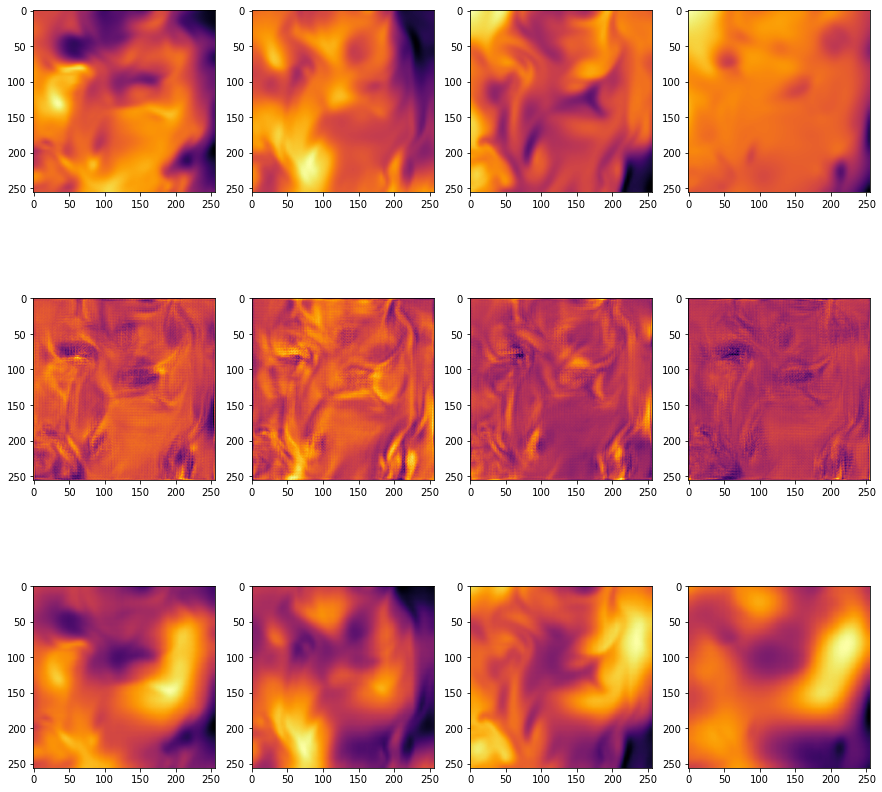

In [ ]:
sample = random.randint(0,600)
#sample = 125
generator.eval()
para = params_data[sample]
para = torch.unsqueeze(para, 0)

test_img = data[sample,0:]
#rand_noise = torch.normal(0, 1, (1, 1, 10, 10)).to(device = 'cuda')
rand_noise = Variable(Tensor(perlin_img_gen_stack(32,32, opt.channels,1, 2)))
rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)
test_img = torch.unsqueeze(test_img,0)

ran_arr = np.random.normal(0, 1, (1, 512))
ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

gen_inp = torch.cat((para,ran_arr), -1)

rand_noise = 1*(rand_noise-0.5) + test_img*0.5

gen = generator(rand_noise, para)
#gen = generator(rand_noise, gen_inp)

test_img = test_img.to(device = 'cpu')
test_img = test_img.detach().numpy()

rand_noise = rand_noise.to(device = 'cpu')
rand_noise = rand_noise.detach().numpy()

#ran_arr = np.random.normal(0, 1, (1, opt.latent_dim))
#ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

#gen_inp = torch.cat((para,ran_arr), -1)

#gen = generator(ran_arr,para)

gen = gen.to(device='cpu').detach().numpy()
#plt.imshow(gen[0,0], cmap = 'inferno')
#plt.figure()
#plt.imshow(gen[0,1], cmap = 'inferno')
#plt.figure()
#plt.imshow(gen[0,2], cmap = 'inferno')
#plt.figure()
#plt.imshow(gen[0,3], cmap = 'inferno')
#plt.figure()

fig,a = plt.subplots(3,4,figsize=(15,15))
a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
a[1][0].imshow(gen[0,0,:,:], cmap='inferno')
a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
a[1][3].imshow(gen[0,3,:,:], cmap='inferno')
a[2][0].imshow(rand_noise[0,0,:,:], cmap='inferno')
a[2][1].imshow(rand_noise[0,1,:,:], cmap='inferno')
a[2][2].imshow(rand_noise[0,2,:,:], cmap='inferno')
a[2][3].imshow(rand_noise[0,3,:,:], cmap='inferno')


In [ ]:
type(rand)

torch.Tensor

In [ ]:
torch.save(generator.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/N16pix2pix_3_gen.pt')
torch.save(discriminator.state_dict(), '/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/N16pix2pix_3_dis.pt')

In [ ]:
generator.load_state_dict(torch.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/Ra_pix2pix_perlin2_1_v4_gen.pt'))
discriminator.load_state_dict(torch.load('/gdrive/MyDrive/Fluid_Sets/Turb_iso_1024/600_points/models/state_dicts/Ra_pix2pix_perlin2_1_v4_dis.pt'))

RuntimeError: ignored

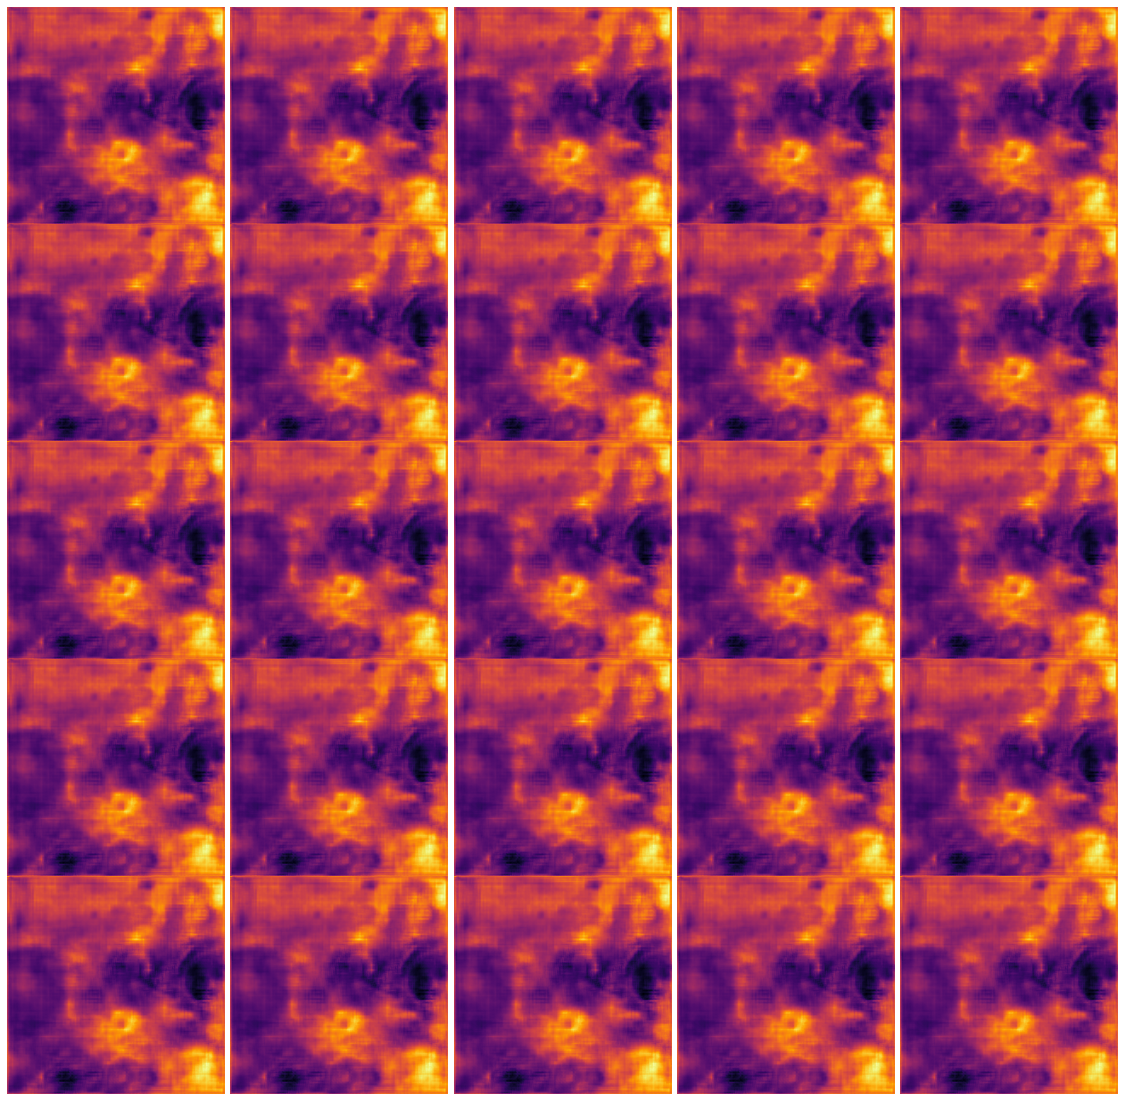

In [ ]:
generator.eval()
n_row = 5
n_col = 5
fig,a = plt.subplots(n_col,n_row,figsize=(20,20))
fig.subplots_adjust(hspace = 0, wspace=0)
for i in range(n_col):
  for j in range(n_row):

    sample = random.randint(0,599)
    sample = 125
    para = params_data[sample]
    para = torch.unsqueeze(para, 0)

    test_img = data[sample,0:]
    test_img = torch.unsqueeze(test_img,0)

    #test_img = test_img.to(device = 'cpu')
    #test_img = test_img.detach().numpy()
    rand_noise = torch.normal(0, 1, (1, 1, 10, 10)).to(device = 'cuda')
    #rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
    rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)

    ran_para = np.random.random_sample((1,9))
    ran_para = torch.tensor(ran_para, dtype=torch.float).to(device = 'cuda')

    rand_noise = 0*(rand_noise-0.5) + test_img*1

    gen_inp = torch.cat((para,ran_arr), -1)

    gen= generator(rand_noise,ran_para)

    gen = gen.to(device='cpu').detach().numpy()

    #plt.imshow(gen[0,0], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,1], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,2], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,3], cmap = 'inferno')
    #plt.figure()

    #fig,a = plt.subplots(2,4,figsize=(15,8))
    #a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
    #a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
    #a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
    #a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
    a[i][j].imshow(gen[0,0,:,:], cmap='inferno')
    a[i,j].set_axis_off()
    #a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
    #a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
    #a[1][3].imshow(gen[0,3,:,:], cmap='inferno')

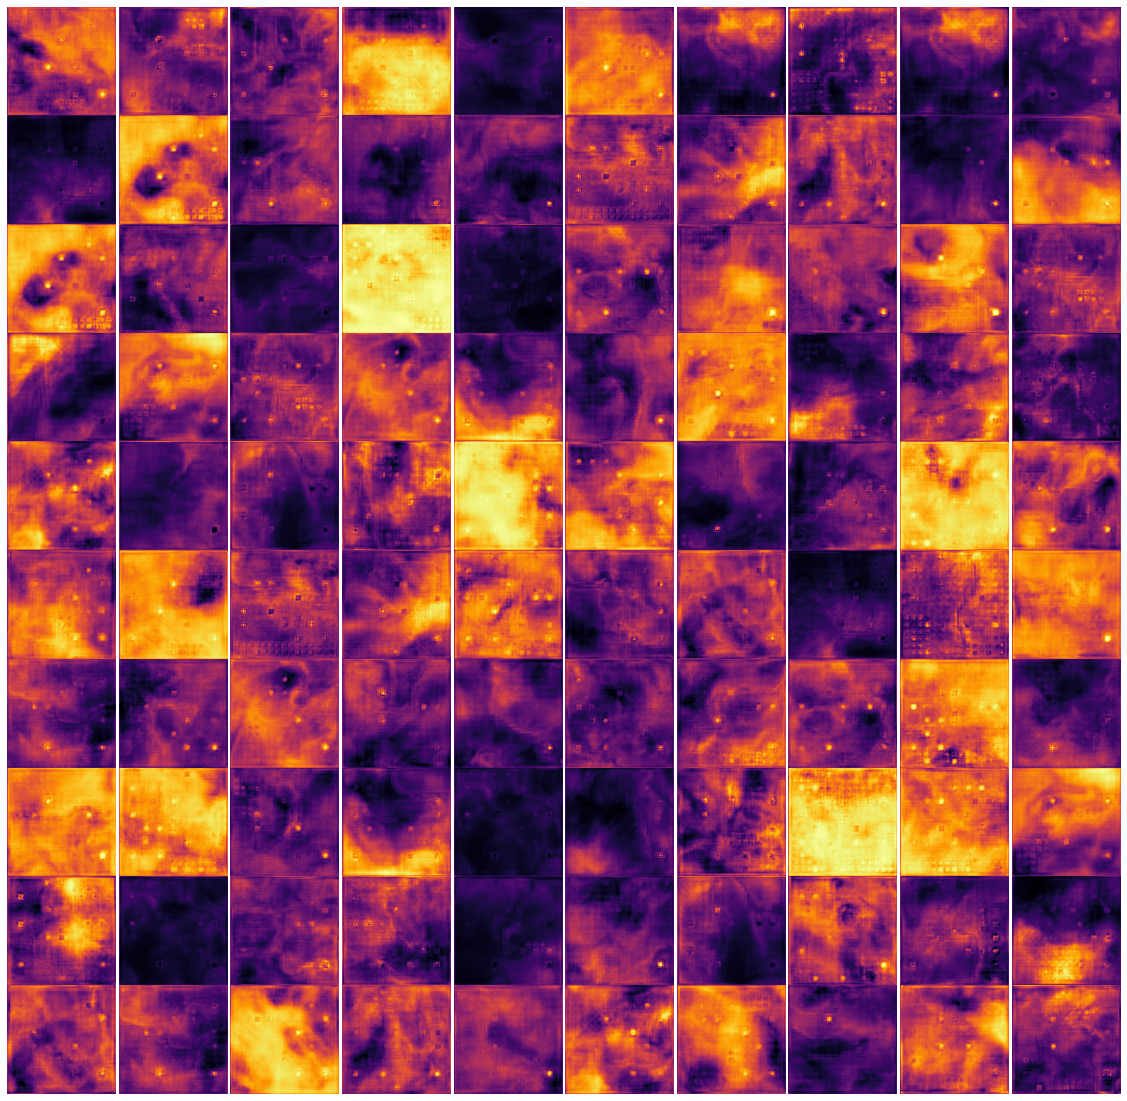

In [ ]:
generator.eval()
n_row = 10
n_col = 10
fig,a = plt.subplots(n_col,n_row,figsize=(20,20))
fig.subplots_adjust(hspace = 0, wspace=0)
for i in range(n_col):
  for j in range(n_row):

    sample = random.randint(0,599)
    para = params_data[sample]
    para = torch.unsqueeze(para, 0)

    test_img = data[sample,0:4]
    test_img = torch.unsqueeze(test_img,0)

    #test_img = test_img.to(device = 'cpu')
    #test_img = test_img.detach().numpy()

    rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
    rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)

    ran_para = np.random.random_sample((1,9))
    ran_para = torch.tensor(ran_para, dtype=torch.float).to(device = 'cuda')

    rand_noise = 1*(rand_noise-0.5) + test_img*0.5

    gen_inp = torch.cat((para,ran_arr), -1)

    gen= generator(rand_noise,ran_para)

    gen = gen.to(device='cpu').detach().numpy()

    #plt.imshow(gen[0,0], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,1], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,2], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,3], cmap = 'inferno')
    #plt.figure()

    #fig,a = plt.subplots(2,4,figsize=(15,8))
    #a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
    #a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
    #a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
    #a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
    a[i][j].imshow(gen[0,0,:,:], cmap='inferno')
    a[i,j].set_axis_off()
    #a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
    #a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
    #a[1][3].imshow(gen[0,3,:,:], cmap='inferno')

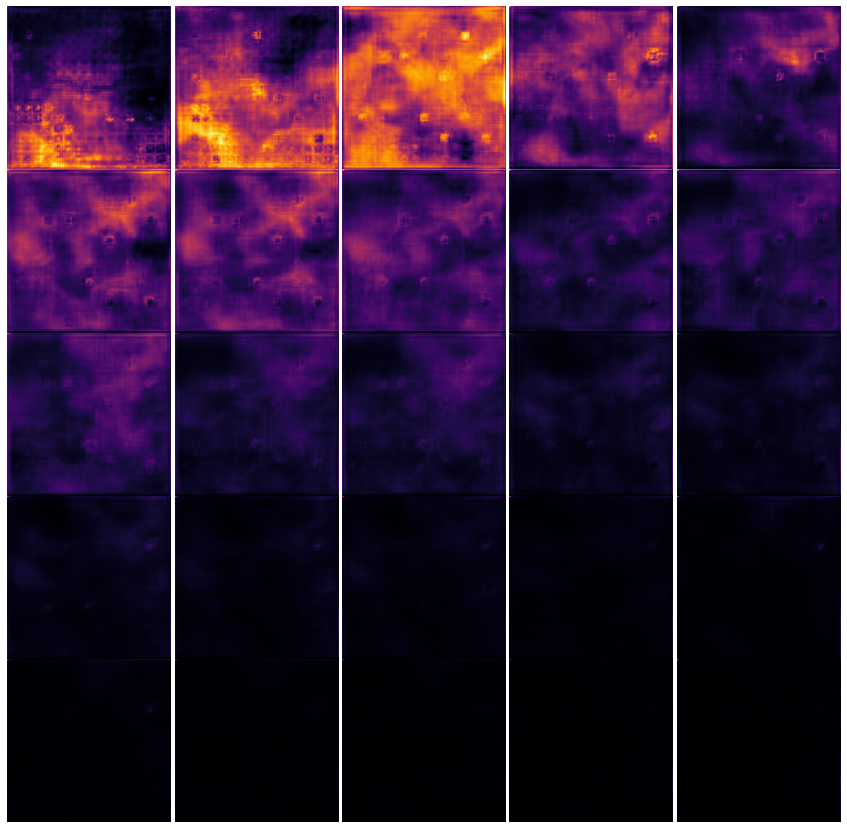

In [ ]:
generator.eval()
n_row = 5
n_col = 5
fig,a = plt.subplots(n_col,n_row,figsize=(15,15))
fig.subplots_adjust(hspace = 0, wspace=0)

#ran_arr = np.random.normal(0, 1, (1, opt.latent_dim))
#ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)

#rand_noise = 1*(rand_noise-0.5) + test_img*0.5

arr1 = np.linspace(-1,1,n_row, dtype=np.float64)
arr2 = np.linspace(1,5,n_col, dtype=np.float64)

#for i in range(n_col):
#  for j in range(n_row):
for i, val1 in enumerate(arr1):
  for j, val2 in enumerate(arr2):

    sample = random.randint(0,599)
    para = params_data[sample]
    para = torch.unsqueeze(para, 0)

    test_img = data[sample,0:4]
    test_img = torch.unsqueeze(test_img,0)

    #test_img = test_img.to(device = 'cpu')
    #test_img = test_img.detach().numpy()
    '''
    rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
    rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)
    '''
    rand_noise = 1*(rand_noise-0.5) + test_img*0.5
    
    ran_para = np.random.random_sample((1,9))
    ran_para = torch.tensor(ran_para, dtype=torch.float).to(device = 'cuda')
    #ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

    n = 1
    #para_ran = torch.normal(0,1,(1,9)).to(device = 'cuda')
    #para_ran = torch.tensor([[  0.1, 0.05 * n * (i - n), 0.1 * n * (j - n), 0.1, 0.1, 0.1, 0.1, 0.1,0.1]]).to(device = 'cuda')
    para_ran = torch.tensor([[val1, val2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype =torch.float64).to(device = 'cuda')
    #gen_inp = torch.cat((para,ran_arr), -1)

    gen = generator(rand_noise,para_ran.float())

    gen = gen.to(device='cpu').detach().numpy()

    #plt.imshow(gen[0,0], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,1], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,2], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,3], cmap = 'inferno')
    #plt.figure()

    #fig,a = plt.subplots(2,4,figsize=(15,8))
    #a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
    #a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
    #a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
    #a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
    a[i][j].imshow(gen[0,0,:,:], cmap='inferno')
    a[i,j].set_axis_off()
    #a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
    #a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
    #a[1][3].imshow(gen[0,3,:,:], cmap='inferno')

In [ ]:
rand_noise.shape

torch.Size([1, 4, 256, 256])

In [ ]:
generator.eval()
n_row = 10
n_col = 10
fig,a = plt.subplots(n_col,n_row,figsize=(15,15))
fig.subplots_adjust(hspace = 0, wspace=0)

#ran_arr = np.random.normal(0, 1, (1, opt.latent_dim))
#ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)

#rand_noise = 1*(rand_noise-0.5) + test_img*0.5

arr1 = np.linspace(-1,1,n_row, dtype=np.float64)
arr2 = np.linspace(1,2,n_col, dtype=np.float64)

#for i in range(n_col):
#  for j in range(n_row):
for i, val1 in enumerate(arr1):


  sample = random.randint(0,599)
  para = params_data[sample]
  para = torch.unsqueeze(para, 0)

  test_img = data[sample,0:4]
  test_img = torch.unsqueeze(test_img,0)

  #test_img = test_img.to(device = 'cpu')
  #test_img = test_img.detach().numpy()
  '''
  rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
  rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)
  '''
  rand_noise = 1*(rand_noise-0.5) + test_img*0.5
  
  ran_para = np.random.random_sample((1,9))
  ran_para = torch.tensor(ran_para, dtype=torch.float).to(device = 'cuda')
  #ran_arr = torch.tensor(ran_arr, dtype=torch.float).to(device = 'cuda')

  n = 1
  #para_ran = torch.normal(0,1,(1,9)).to(device = 'cuda')
  #para_ran = torch.tensor([[ 0.05 * n * (i - n), 0.1 * n * (j - n), 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]).to(device = 'cuda')

  para_ran1 = torch.tensor([[val1, 0.1, 0.1,  rand1, val2, 0.1, 0.1, 0.1, 0.1]], dtype =torch.float64).to(device = 'cuda')

  gen_inp = torch.cat((para,ran_arr), -1)

  gen = generator(rand_noise,para_ran.float())

  gen = gen.to(device='cpu').detach().numpy()

  #plt.imshow(gen[0,0], cmap = 'inferno')
  #plt.figure()
  #plt.imshow(gen[0,1], cmap = 'inferno')
  #plt.figure()
  #plt.imshow(gen[0,2], cmap = 'inferno')
  #plt.figure()
  #plt.imshow(gen[0,3], cmap = 'inferno')
  #plt.figure()

  #fig,a = plt.subplots(2,4,figsize=(15,8))
  #a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
  #a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
  #a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
  #a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
  a[i][j].imshow(gen[0,0,:,:], cmap='inferno')
  a[i][j].set_axis_off()
  #a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
  #a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
  #a[1][3].imshow(gen[0,3,:,:], cmap='inferno')

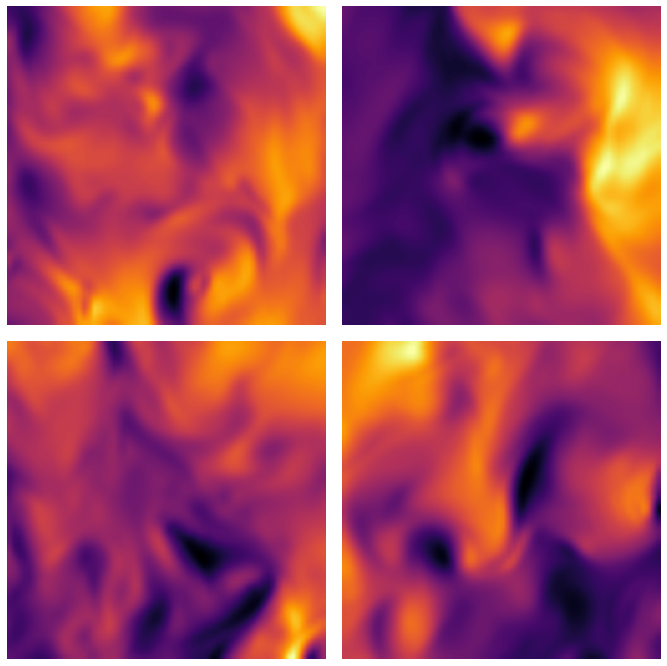

In [ ]:
#generator.eval()
n_row = 2
n_col = 2
fig,a = plt.subplots(n_col,n_row,figsize=(12,12))
fig.subplots_adjust(hspace = 0.05, wspace=0)
sample = [48,54,95,478]
for i in range(n_col):
  for j in range(n_row):

    #sample = random.randint(0,599)
    ind = j * 2 + i
    #para = params_data[sample]
    #para = torch.unsqueeze(para, 0)

    test_img = data[sample,:]
    #test_img = torch.unsqueeze(test_img,0)

    test_img = test_img.to(device = 'cpu')
    test_img = test_img.detach().numpy()

    #rand_noise = Variable(Tensor(perlin_img_gen_stack(8,8, opt.channels,1, 3)))
    #rand_noise = transforms.functional.resize(rand_noise,[256,256],interpolation=transforms.InterpolationMode.BICUBIC)

    #ran_para = np.random.random_sample((1,9))
    #ran_para = torch.tensor(ran_para, dtype=torch.float).to(device = 'cuda')

    #rand_noise = 1*(rand_noise-0.5) + test_img*0.5

    #gen_inp = torch.cat((para,ran_arr), -1)

    #gen= generator(rand_noise,ran_para)

    #gen = gen.to(device='cpu').detach().numpy()

    #plt.imshow(gen[0,0], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,1], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,2], cmap = 'inferno')
    #plt.figure()
    #plt.imshow(gen[0,3], cmap = 'inferno')
    #plt.figure()

    #fig,a = plt.subplots(2,4,figsize=(15,8))
    #a[0][0].imshow(test_img[0,0,:,:], cmap='inferno')
    #a[0][1].imshow(test_img[0,1,:,:], cmap='inferno')
    #a[0][2].imshow(test_img[0,2,:,:], cmap='inferno')
    #a[0][3].imshow(test_img[0,3,:,:], cmap='inferno')
    a[i][j].imshow(test_img[ind,1,:,:], cmap='inferno')
    a[i,j].set_axis_off()
    #a[1][1].imshow(gen[0,1,:,:], cmap='inferno')
    #a[1][2].imshow(gen[0,2,:,:], cmap='inferno')
    #a[1][3].imshow(gen[0,3,:,:], cmap='inferno')

In [ ]:
test_img.shape

(1, 4, 4, 256, 256)